In [1]:
# Future Imports
from __future__ import division, print_function, absolute_import, unicode_literals

# Data Cleaning
from pandas import read_csv, DataFrame, pivot_table
from numpy import NaN, array

# Pairwise-Distance
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import correlation

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Removing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def dataset_load(filepath):
    ''' Loads the Dataset
        ----------
        Parameter: string
        ----------
        Return: dataframe
    '''
    filepath = "./" +filepath+ '.csv'
    dataframe = read_csv(filepath)
    return dataframe

dataframe = dataset_load('reddit_data')

In [3]:
dataframe.head()

,username,subreddit,utc
0,kabanossi,photoshopbattles,1.482748e+09
1,kabanossi,GetMotivated,1.482748e+09
2,kabanossi,vmware,1.482748e+09
3,kabanossi,carporn,1.482748e+09
4,kabanossi,DIY,1.482747e+09


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000000 entries, 0 to 13999999
Data columns (total 3 columns):
username     object
subreddit    object
utc          float64
dtypes: float64(1), object(2)
memory usage: 320.4+ MB


In [5]:
dataframe.describe(include=['O'])

,username,subreddit
count,14000000,14000000
unique,22610,34967
top,Benphyre,AskReddit
freq,1000,1030290


#### Total Number of Unique Users are 22610
#### Total Number of Unique Subreddits are 34967

In [6]:
username = dataframe.groupby(['username'])['subreddit'].nunique() #.value_counts()

In [7]:
subreddits = dataframe.groupby(['subreddit'])['username'].nunique()

In [8]:
top_ten_users = username.sort_values(ascending=False)[:10]

### Users with highest Subreddit Count

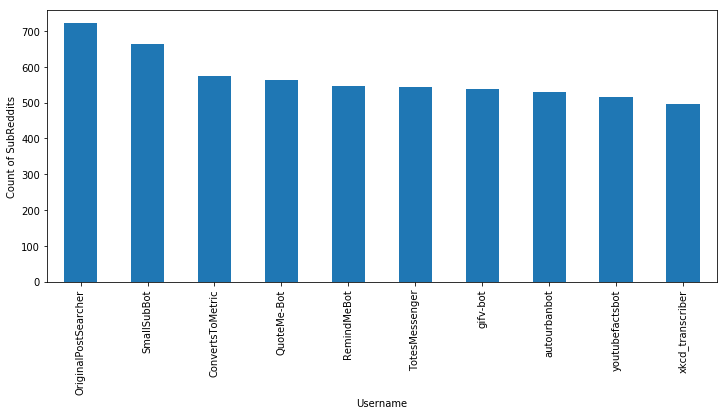

In [9]:
p = top_ten_users.plot(kind='bar', figsize=(12,5), color=sns.color_palette()[0], fontsize=10)
_ = p.set(xlabel='Username', ylabel='Count of SubReddits')

In [10]:
top_ten_subreddits = subreddits.sort_values(ascending=False)[:10]

### Subreddits with highest Frequency

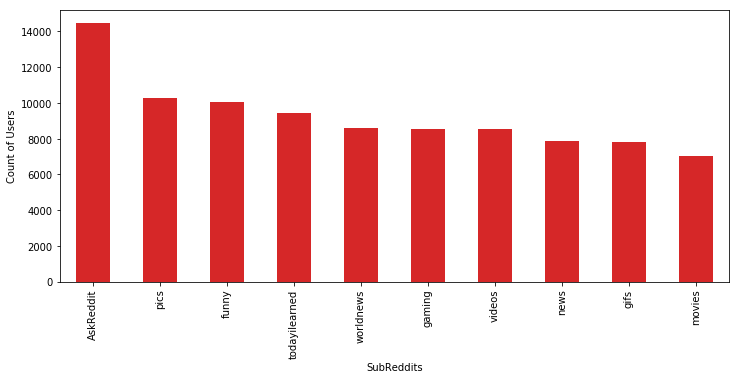

In [11]:
p = top_ten_subreddits.plot(kind='bar', figsize=(12,5), color=sns.color_palette()[3], fontsize=10)
_ = p.set(ylabel='Count of Users', xlabel='SubReddits')

### Finding Out Null Entries

In [12]:
dataframe.isnull().loc[True].sum()

0

In [13]:
dataframe_second = dataframe.copy(deep=True)

In [14]:
# you can also use data.sum(axis=1) here
def dataframe_sampling(data):
    ''' creates a sample fo the original dataframe
        ---------------------
        Parameters: dataframe
        ---------------------
        Return: dataframes
    '''
    dataframe_third = DataFrame(data.groupby(['username'])['subreddit'].value_counts().reset_index(level=0), \
                            columns=['username', 'subreddit'])
    dataframe_third.rename(columns={'subreddit':'count'}, inplace=True)
    dataframe_third = dataframe_third.reset_index()
    data = dataframe_third.sample(frac=0.01)
    data = data.reset_index()
    data = data.drop('index', axis=1)
    pivot_table = data.pivot('subreddit', 'username', 'count').reset_index()
    pivot_table.fillna(value=0, inplace=True)
    return dataframe_third, data, pivot_table

dataframe_third, data, pivot_table = dataframe_sampling(dataframe_second)

In [15]:
pivot_table.subreddit.shape

(3127,)

### Popularity Based Collaborative Filtering Technique (PBCFT)

In [16]:
data2 = data.copy(deep=True)

In [17]:
def popularity_recommendation(data):
    ''' provides a score to the highest subreddit and creates a dataframe
        --------------------
        Parameters: dataframe
        --------------------
        Return: dataframe
    '''
    item_grouped = data.groupby(['subreddit']).agg({'username': 'count'}).reset_index()
    item_grouped.rename(columns={'username': 'score'}, inplace=True)
    item_grouped_sorted = item_grouped.sort_values(['score', 'subreddit'], ascending=False)
    item_grouped_sorted['rank'] = item_grouped_sorted['score'].rank(ascending=False, method='first')
    popularity_recomm = item_grouped_sorted.head(10)
    return popularity_recomm

In [18]:
popularity_recomm = popularity_recommendation(data2)

In [19]:
def recommend(recommend):
    ''' Recommends the popular/ maximum-scored subreddit to the user
        --------------------
        Parameter: dataframe
        --------------------
        Return: dataframe
    '''
    recommend['username'] = raw_input('')
    cols = recommend.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    recommend = recommend[cols]
    recommend.reset_index(inplace=True)
    recommend = recommend.drop('index', axis=1)
    return recommend

In [20]:
recommend(popularity_recomm)

--Sko--


,username,subreddit,score,rank
0,--Sko--,AskReddit,138,1.0
1,--Sko--,pics,120,2.0
2,--Sko--,funny,96,3.0
3,--Sko--,todayilearned,91,4.0
4,--Sko--,worldnews,89,5.0
5,--Sko--,gaming,85,6.0
6,--Sko--,videos,81,7.0
7,--Sko--,gifs,74,8.0
8,--Sko--,news,73,9.0
9,--Sko--,IAmA,73,10.0


* This method is biased towards the maximum occurence of the subreddits. Hence it will only recommend subreddits which is highly popular.
* It does not provide personal wise recommendation based on the subreddit followed.
* Can be useful in recommending hashtags to get maximum followers or get a good amount of reach.

### Item-Item Based Colaborative Filtering Technique (i-iBCFT)

In [21]:
def Distance_of_item(pivot, metric):
    ''' Calculates the distances between two subreddits
        and recommends based on the least distance they have
        ------------------------
        Parameters: dataframe, string
        ------------------------
        Return: dataframe
    '''
    item_pivot_table = pivot.drop('subreddit', axis=1)
#     new_item_pivot_table = DataFrame(index=item_pivot_table.columns, columns=item_pivot_table.columns)
#     item_pivot_table.fillna(0, inplace=True)
    item_pivot_table_distances = 1 - pairwise_distances(item_pivot_table.as_matrix(), metric=metric)
    new_item_pivot_table_distances = DataFrame(item_pivot_table_distances, columns=pivot.subreddit, index=pivot.subreddit)
    return new_item_pivot_table_distances

In [22]:
new_item_pivot_table_correlation_distances = Distance_of_item(pivot_table, 'correlation')
new_item_pivot_table_correlation_distances.head()

subreddit,0x10c,1200isplenty,12in12,18_19,1P_LSD,2007scape,2016Elections,2016Protest,2meirl4meirl,30ROCK,...,yesyesyesyesno,ynab,yoga,youdontsurf,youseeingthisshit,youtube,youtubehaiku,ytp,zelda,zyramains
subreddit,,,,,,,,,,,,,,,,,,,,,
0x10c,1.000000,-0.000196,-0.000155,-0.000155,-0.000155,-0.000219,-0.000155,-0.000155,-0.000295,-0.000155,...,-0.000155,-0.000155,-0.000188,-0.000289,-0.000294,-0.000211,-0.000280,-0.000155,-0.000214,-0.000155
1200isplenty,-0.000196,1.000000,-0.000196,-0.000196,-0.000196,-0.000277,-0.000196,-0.000196,-0.000373,-0.000196,...,-0.000196,-0.000196,-0.000238,-0.000365,-0.000372,-0.000266,-0.000354,-0.000196,-0.000271,-0.000196
12in12,-0.000155,-0.000196,1.000000,-0.000155,-0.000155,-0.000219,-0.000155,-0.000155,-0.000295,-0.000155,...,-0.000155,-0.000155,-0.000188,-0.000289,-0.000294,-0.000211,-0.000280,-0.000155,-0.000214,-0.000155
18_19,-0.000155,-0.000196,-0.000155,1.000000,-0.000155,-0.000219,-0.000155,-0.000155,-0.000295,-0.000155,...,-0.000155,-0.000155,-0.000188,-0.000289,-0.000294,-0.000211,-0.000280,-0.000155,-0.000214,-0.000155
1P_LSD,-0.000155,-0.000196,-0.000155,-0.000155,1.000000,-0.000219,-0.000155,-0.000155,-0.000295,-0.000155,...,-0.000155,-0.000155,-0.000188,-0.000289,-0.000294,-0.000211,-0.000280,-0.000155,-0.000214,-0.000155


In [23]:
new_item_pivot_table_correlation_distances.soccer.sort_values(ascending=False)[0:10]

subreddit
soccer                 1.000000
EdmontonOilers         0.050877
facepalm               0.021906
Colts                  0.004604
thenewcoldwar          0.002169
torrents               0.002169
nattyorjuice           0.002169
FloridaGators          0.002047
BikiniBottomTwitter    0.001821
drunk                  0.000543
Name: soccer, dtype: float64

In [24]:
new_item_pivot_table_cosine_distances = Distance_of_item(pivot_table, 'cosine')

In [25]:
new_item_pivot_table_cosine_distances.soccer.sort_values(ascending=False)[0:10]

subreddit
soccer                 1.000000
EdmontonOilers         0.051128
facepalm               0.022746
Colts                  0.004869
torrents               0.002435
thenewcoldwar          0.002435
nattyorjuice           0.002435
FloridaGators          0.002368
BikiniBottomTwitter    0.002178
drunk                  0.000918
Name: soccer, dtype: float64

In [26]:
new_item_pivot_table_jaccard_distances = Distance_of_item(pivot_table, 'jaccard')

In [27]:
new_item_pivot_table_jaccard_distances.soccer.sort_values(ascending=False)[0:10]

subreddit
soccer                 1.000000
Colts                  0.045455
torrents               0.045455
EdmontonOilers         0.045455
thenewcoldwar          0.045455
nattyorjuice           0.045455
Costco                 0.043478
FloridaGators          0.043478
BikiniBottomTwitter    0.043478
drunk                  0.040000
Name: soccer, dtype: float64

* This approach is better than the previous one as it recommends based on the nearness of a subreddit with the other
* It still does not do a good job as those who are following the 'soccer' subreddit are getting recommendations of 'torrents' and 'drunk' (for Example) which are not related. 
* This technique will be helpful if one wants to show other hashtags which have been used by people who have also used these hashtags.